In [1]:
%cd ..

/home/kimsin98/Adolescent/StructFunc


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
idx = pd.IndexSlice
SEED = 69

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')
colors = sns.color_palette()

In [3]:
from scipy import stats
import statsmodels.api as sm
import joblib
from utils import abcd, residual, permutation

covariates = abcd.load_covariates(covars=['interview_age', 'sex', 'hisp'],
                                  simple_race=True)

In [4]:
fcon, fc_extra = abcd.load_fcon(abcd.OUT_PATH / 'fcon-device-software.csv')
scon, sc_extra = abcd.load_scon(abcd.OUT_PATH / 'scon-device-software.csv')

fcon = abcd.filter_siblings(fcon.loc[fcon.index.intersection(scon.index)], random_state=SEED)
fc_extra = fc_extra.loc[fcon.index]
scon, sc_extra = scon.loc[fcon.index], sc_extra.loc[fcon.index]

subs = fcon.index.get_level_values(0).unique()
print(len(subs), 'subjects')

3483 subjects


# Preprocess

dimension reduction ideas
* genotype: PRS
* phenotype: remove unbalanced features

## Train-Test Split

* 80-20

In [5]:
from sklearn.model_selection import train_test_split

subs_train, subs_test = train_test_split(subs, test_size=.2, random_state=SEED)
fc, fc_test = fcon.loc[subs_train], fcon.loc[subs_test]
sc, sc_test = scon.loc[subs_train], scon.loc[subs_test]

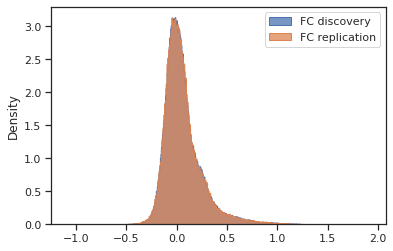

In [6]:
sns.histplot(fc.to_numpy().ravel(), label='FC discovery',
             stat='density', element='step', color=colors[0])
sns.histplot(fc_test.to_numpy().ravel(), label='FC replication',
             stat='density', element='step', color=colors[1])
plt.legend()

plt.show()

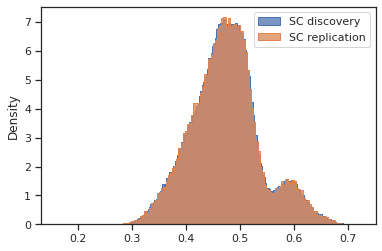

In [7]:
sns.histplot(sc.to_numpy().ravel(), label='SC discovery',
             stat='density', element='step', color=colors[0])
sns.histplot(sc_test.to_numpy().ravel(), label='SC replication',
             stat='density', element='step', color=colors[1])
plt.legend()

plt.show()

## Remove outliers (MAD)

* outlier: deviation > 3 MAD
* exclude if >= 20% missing

In [8]:
fc_med, fc_mad = fc.median(axis=0), stats.median_abs_deviation(fc)
sc_med, sc_mad = sc.median(axis=0), stats.median_abs_deviation(sc)

fc_noout = fc.mask((fc - fc_med).abs().divide(fc_mad) > 3)
sc_noout = sc.mask((sc - sc_med).abs().divide(sc_mad) > 3)

In [9]:
mask_noout = ((fc_noout.notna().sum(axis=1) > fc_noout.shape[1] * .8)
              & (sc_noout.notna().sum(axis=1) > sc_noout.shape[1] * .8))
subs_noout = mask_noout.groupby(level=0).filter(lambda g: g.all()).index

fc, sc = fc_noout.loc[subs_noout], sc_noout.loc[subs_noout]

## Regress out confounds

In [10]:
confounds = fc_extra[['meanmotion']].join(covariates[['sex', 'race', 'hisp']])
fc = residual.residualize(fc, sm.OLS, confounds, n_procs=4)

confounds = sc_extra[['meanmotion']].join(covariates[['sex', 'race', 'hisp']])
sc = residual.residualize(sc, sm.OLS, confounds, n_procs=4)

## Input features

In [11]:
age = covariates.loc[fc.index, 'interview_age'] / 12
age_diff = age.groupby(level=0).diff().dropna().droplevel(1)

In [12]:
dFC = (fc.groupby(level=0).diff().xs(abcd.EVENTS[1], level=1)
       .divide(age_diff, axis=0))
SC = sc.loc[idx[dFC.index, abcd.EVENTS[0]], :].droplevel(1)
FC = fc.loc[idx[dFC.index, abcd.EVENTS[0]], :].droplevel(1)
FCSC = FC.join(SC)

## KNN Impute

In [13]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
dFC = imputer.fit_transform(dFC)
SC = imputer.fit_transform(SC)
FC = imputer.fit_transform(FC)
FCSC = imputer.fit_transform(FCSC)

# Sparse CCA

In [14]:
from gemmr.estimators import SparseCCA

In [15]:
scca_SC = SparseCCA(n_components=10, scale=True, verbose=True)

scca_SC.fit(SC, dFC)
joblib.dump(scca_SC, abcd.OUT_PATH / 'scca_SC.joblib')
print(np.flip(np.sort(scca_SC.corrs_)))

/home/kimsin98/mambaforge/envs/StructFunc/lib/python3.9/site-packages/gemmr/estimators/r_estimators.py:139: UserWarning: More than 1 mode selected: NOT TESTED
  warnings.warn('More than 1 mode selected: NOT TESTED')


[SparseCCA] penalties = [0.4 0.4]
[0.13382346 0.13228717 0.12641457 0.1220372  0.121838   0.11644081
 0.11203999 0.10675007 0.09910173 0.09534623]


In [16]:
scca_FC = SparseCCA(n_components=10, scale=True, verbose=True)

scca_FC.fit(FC, dFC)
joblib.dump(scca_FC, abcd.OUT_PATH / 'scca_FC.joblib')
print(np.flip(np.sort(scca_FC.corrs_)))

/home/kimsin98/mambaforge/envs/StructFunc/lib/python3.9/site-packages/gemmr/estimators/r_estimators.py:139: UserWarning: More than 1 mode selected: NOT TESTED
  warnings.warn('More than 1 mode selected: NOT TESTED')


[SparseCCA] penalties = [0. 0.]
[0.62604476 0.62232562 0.61896574 0.60757692 0.58975517 0.58761892
 0.58347464 0.57737396 0.57526909 0.5743673 ]


In [17]:
scca_FCSC = SparseCCA(n_components=10, scale=True, verbose=True)

scca_FCSC.fit(FCSC, dFC)
joblib.dump(scca_FCSC, abcd.OUT_PATH / 'scca_FCSC.joblib')
print(np.flip(np.sort(scca_FCSC.corrs_)))

/home/kimsin98/mambaforge/envs/StructFunc/lib/python3.9/site-packages/gemmr/estimators/r_estimators.py:139: UserWarning: More than 1 mode selected: NOT TESTED
  warnings.warn('More than 1 mode selected: NOT TESTED')


[SparseCCA] penalties = [0. 0.]
[0.62444286 0.6229708  0.60863383 0.58954308 0.58658355 0.58288995
 0.57785268 0.57747834 0.57543425 0.573014  ]


## Permutation Test

In [29]:
def quick_scca(X, Y):
    scca = SparseCCA(scale=True, optimize_penalties=False,
                     penaltyxs=scca_SC.penaltyx_, penaltyys=scca_SC.penaltyy_)
    scca.fit(X, Y)
    return scca.corrs_[0]

corr_distrib = permutation.permute_func(quick_scca, SC, dFC,
                                        random_state=SEED, n_procs=4)

p = 0.29


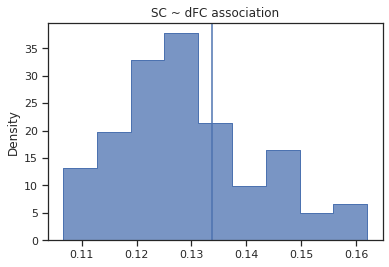

In [42]:
print('p =', ((corr_distrib >= scca_SC.corrs_.max()).sum() + 1) / (len(corr_distrib) + 1))

ax = sns.histplot(corr_distrib, stat='density', element='step')
ax.axvline(x=scca_SC.corrs_.max())
ax.set_title('SC ~ dFC association')
plt.show()

In [44]:
def quick_scca(X, Y):
    scca = SparseCCA(scale=True, optimize_penalties=False,
                     penaltyxs=scca_FC.penaltyx_, penaltyys=scca_FC.penaltyy_)
    scca.fit(X, Y)
    return scca.corrs_[0]

corr_distrib = permutation.permute_func(quick_scca, FC, dFC,
                                        random_state=SEED, n_procs=4)

p = 0.01


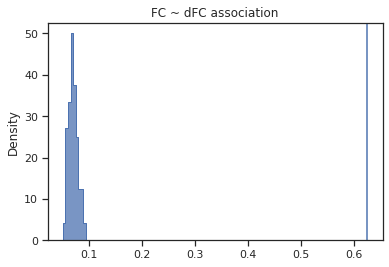

In [45]:
print('p =', ((corr_distrib >= scca_FC.corrs_.max()).sum() + 1) / (len(corr_distrib) + 1))

ax = sns.histplot(corr_distrib, stat='density', element='step')
ax.axvline(x=scca_FC.corrs_.max())
ax.set_title('FC ~ dFC association')
plt.show()